## Multi-classification Network for Image Training

Team member 1 (Katelyn Allen, kallen52@kent.edu)

Team member 2 (Travis Cottrell, tcottre4@kent.edu)

Team member 3 (Austin Brooks, abrook25@kent.edu)

Team member 4 (Eman Khan, ekhan2@kent.edu)

In [ ]:
import numpy as np

In [ ]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         
        self.batch_size = batch_size     
        self.w1 = None             
        self.b1 = None             
        self.w2 = None             
        self.b2 = None             
        self.a1 = None             
        self.losses = []           
        self.val_losses = []       
        self.lr = learning_rate    
        self.l1 = l1               
        self.l2 = l2               

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        
        self.a1 = self.sigmoid(z1)               
        z2 = np.dot(self.a1, self.w2) + self.b2 
        return z2

    def backprop(self, x, err):
        m = len(x)       
        
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
       
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            
        a = 1 / (1 + np.exp(-z))              
        return a
    
    def softmax(self, z):
        z = np.clip(z, -100, None)            
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  
        self.b1 = np.zeros(self.units)                        
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    
        
        for i in range(epochs):
            loss = 0
            print('.', end='')
            
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            
            self.update_val_loss(x_val, y_val)

    
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size 
        if length % self.batch_size:
            bins += 1                    
        indexes = np.random.permutation(np.arange(len(x))) 
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   
            
    def training(self, x, y):
        m = len(x)                
        z = self.forpass(x)       
        a = self.softmax(z)       
        err = -(y - a)            
        
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          
        return np.argmax(z, axis=1)  
    
    def score(self, x, y):
        
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            
        a = self.softmax(z)                
        a = np.clip(a, 1e-10, 1-1e-10)     
        
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [2]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


In [ ]:
import matplotlib.pyplot as plt

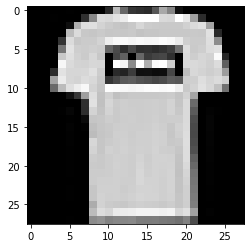

In [ ]:
plt.imshow(x_train_all[1], cmap='gray')
plt.show()

In [ ]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [ ]:
class_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [ ]:
print(class_names[y_train_all[1]])

T-Shirt


In [ ]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [ ]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [ ]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [ ]:
x_train = x_train / 255
x_val = x_val / 255

In [ ]:
x_train = x_train.reshape(-1, 784) # 28 * 28 = 784
x_val = x_val.reshape(-1, 784)

In [ ]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit_transform([0, 1, 3, 1])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [ ]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train) # 0,1,2,3,4,5,6,7,8,9 --> [1,0,0,0,0,0,0,0,0,0] ~ [0,0,0,0,0,0,0,0,0,1]
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [ ]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [ ]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

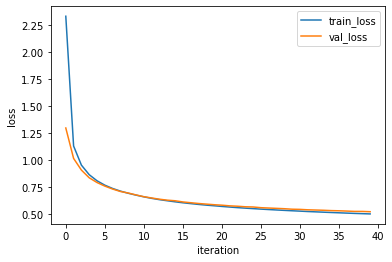

In [ ]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [ ]:
np.random.permutation(np.arange(12000)%10)

array([4, 6, 3, ..., 0, 6, 6])

In [ ]:
np.sum(y_val == np.random.permutation(np.arange(12000)%10)) / 12000

0.10325

## Using Tensorflow




In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_encoded, epochs=40, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 3s 2ms/step - loss: 1.7127 - accuracy: 0.5256 - val_loss: 0.9651 - val_accuracy: 0.7313
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9025 - accuracy: 0.7265 - val_loss: 0.7562 - val_accuracy: 0.7593
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7381 - accuracy: 0.7556 - val_loss: 0.6655 - val_accuracy: 0.7788
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6624 - accuracy: 0.7771 - val_loss: 0.6151 - val_accuracy: 0.7910
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6108 - accuracy: 0.7920 - val_loss: 0.5775 - val_accuracy: 0.8017
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5816 - accuracy: 0.8007 - val_loss: 0.5505 - val_accuracy: 0.8115
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5520 - accuracy: 0.8080 - val_loss: 0.5312 - val_accuracy:

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


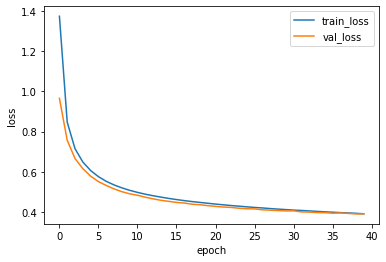

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

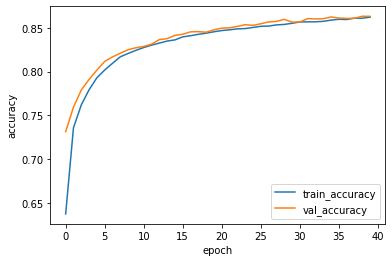

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)

In [ ]:
print(accuracy)

0.8630833625793457
